# Inventor demographics analysis: Female Inventors

In [1]:
import pandas as pd
import os
import re
import numpy as np
import pandas as pd
import pickle
from collections import Counter, defaultdict
import math
import seaborn as sns
import matplotlib.pyplot as plt
from main_analyze import label_vocab
from main_analyze import get_main_data
df_all = get_main_data(assign_net_income_rank_flag=True)

self_licensed_bool_array 919


In [3]:
import gender_guesser.detector as gender
gender_detector = gender.Detector()

def check_name_list_contain_female(inventors_name_list):
    contain_female = False
    gender_list = []
    for name in inventors_name_list:
        first_name = name.split(' ')[0]
        this_gender = gender_detector.get_gender( first_name )
        if this_gender in ['female', 'mostly_female']:
            contain_female = True
            gender_list.append(1) 
        else:
            gender_list.append(0)

    return contain_female, gender_list

from main_analyze import parse_InvNameList
contain_female_list = list()
list_gender_list = list()
df_gender_expended = defaultdict(list)

for idx, row in df_all.iterrows():
    if not isinstance(row['InvNameList'], str):
        inventors_name_list = []
    else:
        inventors_name_list = parse_InvNameList(row['InvNameList'])
    contain_female, gender_list = check_name_list_contain_female(inventors_name_list)
    contain_female_list.append(contain_female)
    list_gender_list.append(gender_list)

    for author_gender in gender_list:
        df_gender_expended['female'].append(author_gender)
        for key in row.keys():
            df_gender_expended[key].append(row[key]) 

df_gender_expended = pd.DataFrame.from_dict(df_gender_expended)
df_all['contain_female'] = contain_female_list
list_gender_list = np.array(list_gender_list, dtype=object)

In [6]:
import statsmodels.api as sm 
from main_analyze import label_vocab
interested_label_vocab = label_vocab[:6] 
X = df_gender_expended[['year'] + interested_label_vocab].astype(float)
Y = df_gender_expended['female'] 
X = sm.add_constant(X) 
logit_mod = sm.OLS(Y, X) 
logit_res = logit_mod.fit()
print(logit_res.summary())
print('p-values:', logit_res.pvalues)




                            OLS Regression Results                            
Dep. Variable:                 female   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     41.14
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           9.43e-58
Time:                        18:20:21   Log-Likelihood:                -4776.7
No. Observations:               13618   AIC:                             9569.
Df Residuals:                   13610   BIC:                             9630.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.9293 

female percentage [0.06557377049180328, 0.03333333333333333, 0.1111111111111111, 0.06637168141592921, 0.09782608695652174, 0.09634551495016612, 0.09271523178807947, 0.1366906474820144, 0.13541666666666666, 0.14209115281501342, 0.1670103092783505, 0.1330049261083744, 0.11092436974789915, 0.1449016100178891, 0.1518578352180937, 0.16903225806451613, 0.14698795180722893, 0.11477761836441894, 0.14516129032258066, 0.15396578538102643, 0.13821138211382114, 0.17746913580246915, 0.16, 0.1490066225165563, 0.16910569105691056, 0.19678714859437751]


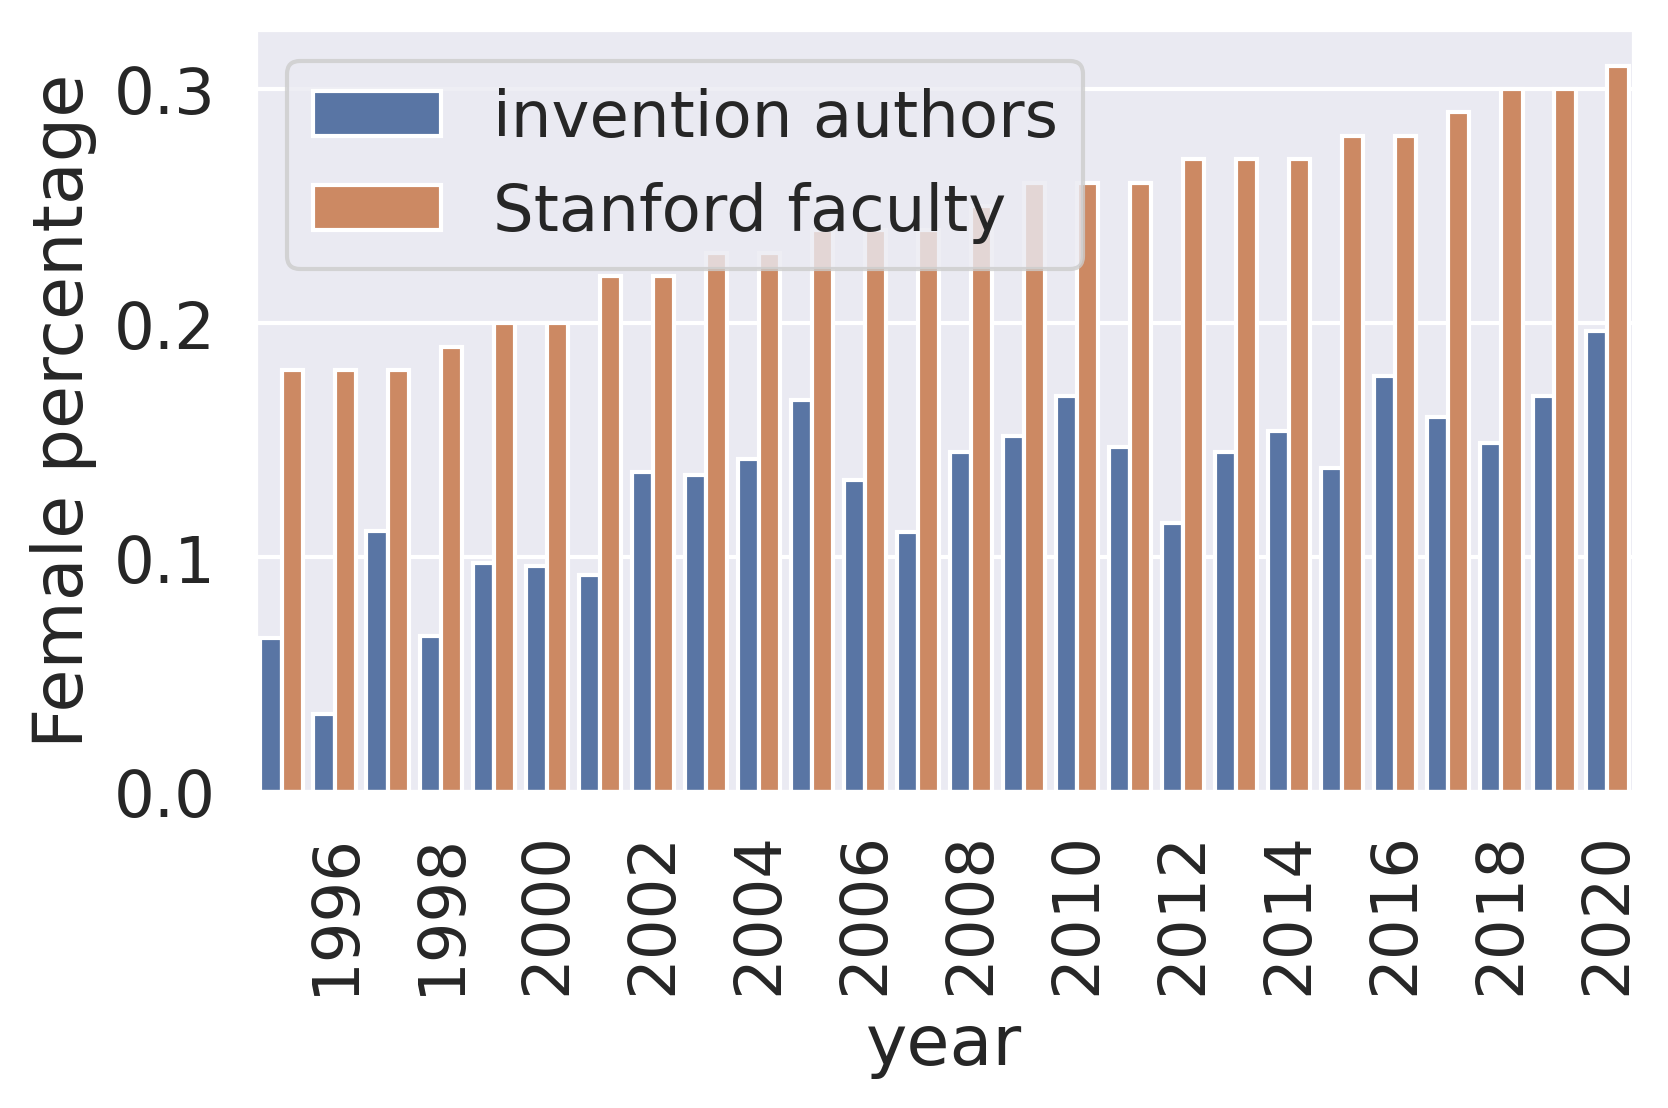

In [23]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set(font_scale=1.4)  
p_value_data_cache = defaultdict(list)
year_start_list = list(range(1995,2021))
for year_start in year_start_list:
    year_end = year_start + 1
    df_year_slice = df_all.eval(" `Disclosure Date`>='{}-01-01'  and `Disclosure Date`<'{}-01-01' ".format(year_start, year_end))

    year_gender_list = list()
    for gender_list in list_gender_list[df_year_slice]:
        year_gender_list.extend(gender_list)

    p_value_data_cache['female percentage'].append(np.mean(year_gender_list)) 

print('female percentage', p_value_data_cache['female percentage'])

df_patents = pd.DataFrame.from_dict({
    'year': year_start_list, 
    'female percentage': p_value_data_cache['female percentage'],
    '': ['invention authors'] * len(year_start_list),
    })
df_faculty = df_patents.copy()
df_faculty[''] = ['Stanford faculty'] * len(year_start_list)
df_faculty['female percentage'] = [
    0.18, 0.18, 0.18, 0.19, 0.20, # 1995-1999
    0.20, 0.22, 0.22, 0.23, 0.23, # 2000-2004
    0.24, 0.24, 0.24, 0.25, 0.26, # 2005-2009
    0.26, 0.26, 0.27, 0.27, 0.27, # 2010-2014
    0.28, 0.28, 0.29, 0.30, 0.30, # 2015-2019
    0.31, # 2020, 
    # data from: https://ideal.stanford.edu/ideal-faculty-dashboard
    # 2019 Report of the Faculty
    # 20 years of faculty growth
    # https://facultydevelopment.stanford.edu/data-reports/faculty-demographics
]
df = pd.concat([df_patents, df_faculty])

ax = sns.barplot(data=df, x='year', y='female percentage', hue='')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Female percentage')

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 2 == 1:  
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("notebook_plots/female_percentage.jpg") 
plt.show()

